# Libraries

In [40]:


# Core libraries
import os
import io
import re
import json
import ast
import time
import zipfile
import warnings
import math
import pickle
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Data handling
import numpy as np
import pandas as pd

# Excel handling
import openpyxl
import pyxlsb

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical tools
from scipy.stats import entropy, norm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Binning and feature engineering
import optbinning
from optbinning import BinningProcess, ContinuousOptimalBinning, OptimalBinning

# Machine learning - Scikit-learn
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
)

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier,
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import metrics, preprocessing
from sklearn.datasets import make_classification
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    make_scorer, balanced_accuracy_score, roc_curve
)

from catboost import CatBoostClassifier

# XGBoost & LightGBM
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

# Streamlit (for UI/app development)
import streamlit as st
from streamlit.runtime.scriptrunner import RerunException, get_script_run_ctx


# Folder Path Development Data

In [41]:
# Latest Cube name
month_V1="MAY25"

# Scoring Month name(for which month you want to score)
month_scoring=["MAY25"]

# Main file/Export File location
path_main=rf"D:\Pranto\Working\Collection Model\Collection New Model\3 to 3 Plus PV\Final Model Files\Model Used File"

# Main data file name(Development data)
file_name_development = "3 TO 3 PLUS JAN24 TO MAR25_PV_MODEL_Overall Data_apply_binning_Data"


# Model Pickle file name
model_file_name_development = "3_TO_3_PLUS_JAN24_TO_MAR25_PV_MODEL_Overall_Data_apply_binning_Data_Random_Forest_model_Pickle file"


# Export File Name
export_file_name =rf"New_PV_3_3+_{month_V1}"

# Folder Path Export File location and Scoring File location

In [42]:
path_scoring=rf"D:\Pranto\Working\Collection Model\Collection New Model\3 to 3 Plus PV\Model Scoring\Base for Scoring"

file_scoring=rf"PV 3 to 3+ Scoring file with all variables_{month_V1}_apply_binning V1"

# Import Required Files

In [43]:
# Import Development Data
try:
    df=pd.read_csv(rf"{path_main}\{file_name_development}.csv",encoding='latin-1')

except:
    df=pd.read_excel(rf"{path_main}\{file_name_development}.xlsx")


# Import Model Pickle file

with open(rf"{path_main}\{model_file_name_development}.pkl", 'rb') as file:
    model = pickle.load(file)

# Import Scoring Data
try:
    df_scoring=pd.read_csv(rf"{path_scoring}\{file_scoring}.csv",encoding='latin-1')
except:
    df_scoring=pd.read_excel(rf"{path_scoring}\{file_scoring}.xlsx")



print(f"Development Data shape: {df.shape}")

print(f"Scoring Data shape: {df_scoring.shape}")

print(f"Model Pickle file loaded successfully.",model)

df.head(3).head(3)

Development Data shape: (22860, 273)
Scoring Data shape: (1137, 267)
Model Pickle file loaded successfully. RandomForestClassifier(max_depth=5, random_state=42)


CONNO  TENURE SCHEME_FINPROD  IRR_CUSTOMER  ASSET_COST PDC_FLAG  \
0  5002302216      93     SALARIED17         9.263    608218.0     NACH   
1  5002302216      93     SALARIED17         9.263    608218.0     NACH   
2  5002330975      93        SE_7YRS        10.512    579782.0     NACH   

   COMPANY_CODE  COLLECTION_TILL_DATE       SOHP          BPNO  ...  \
0          5000             767504.00   18991.05  2.002945e+09  ...   
1          5000             776904.00    9788.47  2.002945e+09  ...   
2          5000             779399.08  128480.63  2.002968e+09  ...   

   CountInBkt_3Plus_12M_WOE  CountInBkt_3Plus_24M_WOE  RollFw1_WOE  \
0                  0.110418                  0.111299    -1.207397   
1                  0.110418                  0.111299     0.697907   
2                  0.110418                  0.111299    -1.207397   

   RollFw2_WOE RollFw3_WOE  RollFw6_WOE  Roll_stable_2_WOE Roll_stable_3_WOE  \
0    -0.728023   -1.277657    -1.200428          -0.714204         -0.942113   
1    -0.728023   -0.417791    -1.200428          -0.714204         -0.431774   
2    -0.728023   -0.417791    -1.200428          -0.714204         -0.431774   

     CE_WOE  TENURE1_WOE  
0  0.220837     -0.04612  
1  0.832978     -0.04612  
2  0.220837     -0.04612  

[3 rows x 273 columns]

# Identify Models and Features

In [44]:


# Function to get model name from class
def detect_model_type(model):
    if isinstance(model, LogisticRegression):
        return "Logistic Regression"
    elif isinstance(model, RandomForestClassifier):
        return "Random Forest"
    elif isinstance(model, DecisionTreeClassifier):
        return "Decision Tree"
    elif isinstance(model, xgb.XGBClassifier):
        return "XGBoost"
    elif isinstance(model, lgb.LGBMClassifier):
        return "LightGBM"
    elif isinstance(model, CatBoostClassifier):
        return "CatBoost"
    else:
        return type(model).__name__

# Function to extract feature names
def get_feature_names(model):
    if hasattr(model, 'feature_names_in_'):  
        return model.feature_names_in_
    if isinstance(model, xgb.XGBClassifier):
        try:
            return model.get_booster().feature_names
        except:
            return model.feature_names
    if isinstance(model, lgb.LGBMClassifier):
        try:
            return model.booster_.feature_name()
        except:
            return model.feature_name_
    if isinstance(model, CatBoostClassifier):
        return model.feature_names_
    raise ValueError("Unable to extract features for model type:", type(model))



# === Detect model type ===
model_type = detect_model_type(model)
print(f"Detected model type: {model_type}")

# === Get features ===
try:
    top_features = get_feature_names(model)
except Exception as e:
    raise ValueError(f"Could not get feature names: {e}")

top_features=list(top_features)
print("Top features:",len(top_features),"\n",top_features)
# # === Predict on new data ===
# try:
#     predictions = model.predict(new_data[features])
#     print("Prediction head:\n", predictions[:5])
# except Exception as e:
#     raise RuntimeError(f"Error during prediction: {e}")


Detected model type: Random Forest
Top features: 10 
 ['CountInBkt_3_3M_WOE', 'Roll_stable_2_WOE', 'due_date_WOE', 'RollFw2_WOE', 'last_Month_coll_WOE', 'CountInBkt_2Plus_3M_WOE', 'nuof_EMI_L3M_WOE', 'DSA_DLR_WOE', 'BRANCH_WOE', 'PRODUCT_New_WOE']


# Append Files

In [45]:
# Append train and test files
df=pd.concat([df, df_scoring], ignore_index=True)

print(f"Combined Data shape: {df.shape}")


Combined Data shape: (23997, 273)


# Input

In [46]:
df['MONTH'].unique()

array(['JAN25', 'FEB25', 'FEB24', 'MAR24', 'APR24', 'MAY24', 'SEP24',
       'OCT24', 'JAN24', 'MAR25', 'AUG24', 'NOV24', 'JUL24', 'DEC24',
       'JUN24', 'MAY25'], dtype=object)

In [47]:
# Target Columns
selected__target_column ='TARGET_VARIABLE_V1'

# Key Columns
drop_columns1=['CONNO','BPNO','COMPANY_CODE','ODBKT','PRODUCT','ASSET_CATEGORY2']



# Selected columns for separate train and test data
# month='NONE' # Don't want to select train and test data based on month
month='MONTH'


month_column=month

# Selected months for train data
train_months=[
'JAN24', 'FEB24', 'MAR24', 'APR24', 'MAY24', 'JUN24','JUL24', 'AUG24', 'SEP24',
        'OCT24', 'NOV24', 'DEC24'
]

# test_months=[
# 'JAN25', 'FEB25',
#        'MAR25'
# ]

test_months= month_scoring




# Model used Variables
drop_columns=drop_columns1+[selected__target_column]+[month]
# other_columns=final_variables_list
# Prepare data
df = df[drop_columns+top_features]
DATA = df
train_data = df if month == "NONE" else df[df[month].isin(train_months)]

X_train = train_data.drop(drop_columns, axis=1)
y_train = train_data[selected__target_column]


# # Select Models diff_models=['Logistic Regression', 'Random Forest', 'Decision Tree', 'XGBoost', 'LightGBM', 'CatBoost']
# diff_models = ['Logistic Regression', 'Random Forest', 'Decision Tree', 'XGBoost', 'LightGBM', 'CatBoost']
# models_prev = 'Random Forest'
# models = 'Random Forest'

# Model Scoring

In [48]:

#############%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#############%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# Define the ks_table function
def ks_table(data_frame, pred_col_name='Probability', true_col_name='Target', responder_default=1, dec_no=10):
    ascending_df = data_frame.sort_values(by=pred_col_name, ascending=False)
    length_df = len(data_frame)
    decile_len = length_df // dec_no
    total_resp = data_frame[true_col_name].value_counts().loc[1]
    total_non_resp = data_frame[true_col_name].value_counts().loc[0]
    temp_ks = pd.DataFrame({
        'Decile': [i + 1 for i in range(dec_no)],
        'Total Population': [decile_len] * dec_no,
        'Max Probability': [np.nan] * dec_no,
        'Min Probability': [np.nan] * dec_no,
        'Good': [np.nan] * dec_no,
        'Bad': [np.nan] * dec_no,
        'Good %': [np.nan] * dec_no,
        'Bad %': [np.nan] * dec_no,
        'Cumulative Good %': [np.nan] * dec_no,
        'Cumulative Bad %': [np.nan] * dec_no,
        'Difference': [np.nan] * dec_no
    })
    cum_prec_responders = 0
    cum_prec_non_responders = 0
    for j in range(dec_no):
        if j < dec_no - 1:
            temp_df = ascending_df.iloc[decile_len * j:decile_len * (j + 1)]
        else:
            temp_df = ascending_df.iloc[decile_len * j:]
        min_prob = min(temp_df[pred_col_name])
        max_prob = max(temp_df[pred_col_name])
        try:
            non_responders = temp_df[true_col_name].value_counts().loc[0]
        except KeyError:
            non_responders = 0
        try:
            responders = temp_df[true_col_name].value_counts().loc[1]
        except KeyError:
            responders = 0
        prec_responders = responders / total_resp
        prec_non_responders = non_responders / total_non_resp
        cum_prec_responders = prec_responders + cum_prec_responders
        cum_prec_non_responders = prec_non_responders + cum_prec_non_responders
        diff = cum_prec_responders - cum_prec_non_responders
        temp_ks.loc[j, 'Max Probability'] = format(max_prob, 'f')
        temp_ks.loc[j, 'Min Probability'] = format(min_prob, 'f')
        temp_ks.loc[j, 'Good'] = int(non_responders)
        temp_ks.loc[j, 'Bad'] = int(responders)
        temp_ks.loc[j, 'Good %'] = prec_non_responders
        temp_ks.loc[j, 'Bad %'] = prec_responders
        temp_ks.loc[j, 'Cumulative Good %'] = cum_prec_non_responders
        temp_ks.loc[j, 'Cumulative Bad %'] = cum_prec_responders
        temp_ks.loc[j, 'Difference'] = format(diff, 'f')

    return temp_ks

# Define the ks_table_TEST function
def ks_table_TEST(data_frame, pred_col_name='Probability', true_col_name='Target', responder_default=1, dec_no=10, min_max_ranges=None):
    if min_max_ranges is None or len(min_max_ranges) != dec_no:
        raise ValueError("min_max_ranges must be provided and should have a length equal to dec_no")

    # Sort the DataFrame by the prediction probabilities in descending order
    ascending_df = data_frame.sort_values(by=pred_col_name, ascending=False)
    
    # Prepare the KS table DataFrame
    temp_ks = pd.DataFrame({
        'Decile': [i + 1 for i in range(dec_no)],
        'Total Population': [np.nan] * dec_no,
        'Max Probability': [np.nan] * dec_no,
        'Min Probability': [np.nan] * dec_no,
        'Good': [np.nan] * dec_no,
        'Bad': [np.nan] * dec_no,
        'Good %': [np.nan] * dec_no,
        'Bad %': [np.nan] * dec_no,
        'Cumulative Good %': [np.nan] * dec_no,
        'Cumulative Bad %': [np.nan] * dec_no,
        'Difference': [np.nan] * dec_no
    })
    
    total_resp = data_frame[true_col_name].value_counts().get(1, 0)
    total_non_resp = data_frame[true_col_name].value_counts().get(0, 0)
    
    cum_prec_responders = 0
    cum_prec_non_responders = 0

    for j in range(dec_no):
        min_prob, max_prob = min_max_ranges[j]
        
        # Filter rows in the current decile range
        temp_df = ascending_df[(ascending_df[pred_col_name] >= min_prob) & (ascending_df[pred_col_name] <= max_prob)]
        
        total_pop = len(temp_df)
        non_responders = temp_df[true_col_name].value_counts().get(0, 0)
        responders = temp_df[true_col_name].value_counts().get(1, 0)
        
        prec_responders = responders / total_resp if total_resp != 0 else 0
        prec_non_responders = non_responders / total_non_resp if total_non_resp != 0 else 0
        
        cum_prec_responders += prec_responders
        cum_prec_non_responders += prec_non_responders
        
        diff = cum_prec_responders - cum_prec_non_responders
        
        temp_ks.loc[j, 'Total Population'] = total_pop
        temp_ks.loc[j, 'Max Probability'] = format(max_prob, 'f')
        temp_ks.loc[j, 'Min Probability'] = format(min_prob, 'f')
        temp_ks.loc[j, 'Good'] = int(non_responders)
        temp_ks.loc[j, 'Bad'] = int(responders)
        temp_ks.loc[j, 'Good %'] = prec_non_responders
        temp_ks.loc[j, 'Bad %'] = prec_responders
        temp_ks.loc[j, 'Cumulative Good %'] = cum_prec_non_responders
        temp_ks.loc[j, 'Cumulative Bad %'] = cum_prec_responders
        temp_ks.loc[j, 'Difference'] = format(diff, 'f')
    
    return temp_ks

In [49]:


if month=="NONE":

    # # Separate features (X) and target (y) for training data
    X_train = train_data.drop(drop_columns, axis=1)
    # y_train = train_data['TARGET']

    # X_train=X_train_selected
    # X_train=X_train.iloc[:, top_features_indices]
    X_train=X_train[top_features]
    y_train=train_data[selected__target_column]




    # Fit the model
    model.fit(X_train,y_train)

    # Calculate the optimal threshold based on ROC curve for training data
    y_prob_cutoff_train = model.predict_proba(X_train)[:, 1]
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_prob_cutoff_train)
    optimal_idx_train = np.argmax(tpr_train - fpr_train)
    optimal_threshold = thresholds_train[optimal_idx_train]

    y_pred_train = np.where(y_prob_cutoff_train >= optimal_threshold, 1, 0)

    # Print evaluation metrics for training data
    cm_train = confusion_matrix(y_train, y_pred_train, labels=model.classes_)
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=model.classes_)
    disp_train.plot()
    # plt.show()

    # Calculate KS table for training data
    predictions_train = pd.DataFrame({'Target': y_train, 'Probability': y_prob_cutoff_train})
    ks_table_train = ks_table(predictions_train, pred_col_name='Probability', true_col_name='Target', responder_default=1, dec_no=10)



    # Add columns to Train data

    # Add the required columns to train_data
    train_data['Probability'] = y_prob_cutoff_train

    # Step: Add Decile column to train_data based on ks_table_train ranges

    def assign_decile(prob, ks_table_df):
        for i, row in ks_table_df.iterrows():
            if float(row['Min Probability']) <= prob <= float(row['Max Probability']):
                return row['Decile']
        return np.nan  # if not matched (optional safeguard)

    train_data['Decile_V0'] = train_data['Probability'].apply(lambda x: assign_decile(x, ks_table_train))



    # Dictionary to store KS tables and concatenated DataFrames for each test month
    ks_tables_test = {}
    decile_dfs = {}

    # all data with top features

    all_data=[train_data]

    final_data = pd.concat(all_data, ignore_index=True)
    required_columnss=drop_columns1+[month_column]+[selected__target_column]+top_features+['Decile','Probability']
    final_data=final_data[required_columnss]


else:
    # # Separate features (X) and target (y) for training data
    X_train = train_data.drop(drop_columns, axis=1)
    # y_train = train_data['TARGET']

    # X_train=X_train_selected
    # X_train=X_train.iloc[:, top_features_indices]
    X_train=X_train[top_features]
    y_train=train_data[selected__target_column]




    # Fit the model
    model.fit(X_train,y_train)

    # Calculate the optimal threshold based on ROC curve for training data
    y_prob_cutoff_train = model.predict_proba(X_train)[:, 1]
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_prob_cutoff_train)
    optimal_idx_train = np.argmax(tpr_train - fpr_train)
    optimal_threshold = thresholds_train[optimal_idx_train]

    y_pred_train = np.where(y_prob_cutoff_train >= optimal_threshold, 1, 0)

    # Print evaluation metrics for training data
    # cm_train = confusion_matrix(y_train, y_pred_train, labels=model.classes_)
    # disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=model.classes_)
    # disp_train.plot()
    # plt.show()

    # Calculate KS table for training data
    predictions_train = pd.DataFrame({'Target': y_train, 'Probability': y_prob_cutoff_train})
    ks_table_train = ks_table(predictions_train, pred_col_name='Probability', true_col_name='Target', responder_default=1, dec_no=10)



    # Add columns to Train data

    # Add the required columns to train_data
    train_data['Probability'] = y_prob_cutoff_train

    # Step: Add Decile column to train_data based on ks_table_train ranges

    def assign_decile(prob, ks_table_df):
        for i, row in ks_table_df.iterrows():
            if float(row['Min Probability']) <= prob <= float(row['Max Probability']):
                return row['Decile']
        return np.nan  # if not matched (optional safeguard)

    train_data['Decile_V0'] = train_data['Probability'].apply(lambda x: assign_decile(x, ks_table_train))



    # Dictionary to store KS tables and concatenated DataFrames for each test month
    ks_tables_test = {}
    decile_dfs = {}

    # all data with top features

    all_data=[train_data]

    # Loop through each test month and evaluate the model
    for months in test_months:
        

        test_data = DATA[DATA[month_column] == months]

        # Separate features (X) and target (y) for testing data
        X_test = test_data.drop(drop_columns, axis=1)
        # X_test=X_test_selected
        X_test=X_test[top_features]
        y_test = test_data[selected__target_column]

        # Apply the optimal threshold to the test set
        y_prob_cutoff_test = model.predict_proba(X_test)[:, 1]
        y_prob_test_with_cutoff = np.where(y_prob_cutoff_test >= optimal_threshold, 1, 0)



            # Add the required columns to test_data

        test_data['Probability'] = y_prob_cutoff_test

        # Step: Add Decile column to train_data based on ks_table_train ranges

        def assign_decile(prob, ks_table_df):
            for i, row in ks_table_df.iterrows():
                if float(row['Min Probability']) <= prob <= float(row['Max Probability']):
                    return row['Decile']
            return np.nan  # if not matched (optional safeguard)

        test_data['Decile_V0'] = test_data['Probability'].apply(lambda x: assign_decile(x, ks_table_train))

        # For Equal Decile
        test_data = test_data.sort_values('Probability', ascending=False).reset_index(drop=True)
        # test_data['Decile'] = pd.qcut(test_data['Probability'], 10, labels=False) + 1

        # Use rank to break ties and apply qcut
        test_data['Decile'] = pd.qcut(test_data['Probability'].rank(method='first'),q=10,labels=False) + 1  # Deciles from 1 to 10

        # Plot the confusion matrix
        # cm = confusion_matrix(y_test, y_prob_test_with_cutoff, labels=model.classes_)
        # disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
        # disp.plot()
        # plt.show()

        # Calculate and store KS table in dictionary with DataFrame name including month
        predictions_val = pd.DataFrame({'Target': y_test, 'Probability': y_prob_cutoff_test})
        min_max_ranges = [(np.float32(row['Min Probability']), np.float32(row['Max Probability'])) for _, row in ks_table_train.iterrows()]
        ks_table_test = ks_table_TEST(predictions_val, pred_col_name='Probability', true_col_name='Target', responder_default=1, dec_no=10, min_max_ranges=min_max_ranges)
        ks_tables_test[f"KS_TABLE_{months}"] = ks_table_test



            # Append the test data for the month to the all_data list
        all_data.append(test_data)

    # Concatenate all the data (train and test data) into a single DataFrame
    final_data = pd.concat(all_data, ignore_index=True)
    required_columnss=drop_columns1+[month_column]+[selected__target_column]+top_features+['Decile_V0','Decile','Probability']
    final_data=final_data[required_columnss]


C:\Users\524264.CORP\AppData\Local\Temp\ipykernel_17532\227724692.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.734429' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  temp_ks.loc[j, 'Max Probability'] = format(max_prob, 'f')
C:\Users\524264.CORP\AppData\Local\Temp\ipykernel_17532\227724692.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.479266' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  temp_ks.loc[j, 'Min Probability'] = format(min_prob, 'f')
C:\Users\524264.CORP\AppData\Local\Temp\ipykernel_17532\227724692.py:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.329881' has dtype incompatible with float64, please explicitly cast to a c

In [50]:
optimal_threshold

0.19881243522948808

# Maximum Score at Groupby level for Only Test Data

In [51]:



# Filter the data for only test month
final_data_V1 = final_data[final_data[month_column].isin(test_months)]


result = final_data_V1.groupby('BPNO', as_index=False).agg({'Probability': 'max'}).rename(columns={'Probability': 'Pred_Score_1'})

final_data_V2 = pd.merge(final_data_V1, result, on='BPNO', how='left')

df_test_V3=final_data_V2[drop_columns1+[month_column]+['Decile_V0','Decile','Probability','Pred_Score_1']]


print(f"Final Data shape: {df_test_V3.shape}")
print(f"Test Months:", df_test_V3[month_column].unique().tolist())
print(f"Check Null values in Decile_V0 column: {df_test_V3['Decile_V0'].isnull().sum()}")
print(f"Check Null values in Decile column: {df_test_V3['Decile'].isnull().sum()}")
print(f"Final Data columns: {df_test_V3.columns.tolist()}")

df_test_V3.head(4)

Final Data shape: (1137, 11)
Test Months: ['MAY25']
Check Null values in Decile_V0 column: 1
Check Null values in Decile column: 0
Final Data columns: ['CONNO', 'BPNO', 'COMPANY_CODE', 'ODBKT', 'PRODUCT', 'ASSET_CATEGORY2', 'MONTH', 'Decile_V0', 'Decile', 'Probability', 'Pred_Score_1']


CONNO          BPNO  COMPANY_CODE  ODBKT       PRODUCT  \
0  5003603231  2.003984e+09          5000      3  TIAGO PETROL   
1  5003214571  2.003732e+09          5000      3      NEXON XM   
2  5003226123  2.003743e+09          5000      3  TIAGO PETROL   
3  5002985061  2.003517e+09          5000      3       ZEST XM   

  ASSET_CATEGORY2  MONTH  Decile_V0  Decile  Probability  Pred_Score_1  
0             CAR  MAY25        1.0    10.0     0.712038      0.712038  
1             MUV  MAY25        1.0    10.0     0.712038      0.712038  
2             CAR  MAY25        1.0    10.0     0.712038      0.712038  
3             CAR  MAY25        1.0    10.0     0.711670      0.711670

In [52]:
df_test_V3['Decile'].value_counts(normalize=True).sort_index()

Decile
1.0     0.100264
2.0     0.100264
3.0     0.099384
4.0     0.100264
5.0     0.100264
6.0     0.099384
7.0     0.100264
8.0     0.099384
9.0     0.100264
10.0    0.100264
Name: proportion, dtype: float64

In [53]:
df_test_V3['Decile_V0'].value_counts(normalize=True).sort_index()

Decile_V0
1.0     0.072183
2.0     0.220070
3.0     0.084507
4.0     0.093310
5.0     0.086268
6.0     0.063380
7.0     0.139085
8.0     0.036092
9.0     0.093310
10.0    0.111796
Name: proportion, dtype: float64

# Train Model Results

2025-06-04 23:34:12.391 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Accuracy 0.7721
Precision 0.3961
F1 Score 0.5100
Recall 0.7161
Balanced Accuracy 0.7496
ROC AUC: 0.7496
##################################################################
**Classification Report:**
              precision    recall  f1-score   support

         0.0       0.93      0.78      0.85     15999
         1.0       0.40      0.72      0.51      3177

    accuracy                           0.77     19176
   macro avg       0.66      0.75      0.68     19176
weighted avg       0.84      0.77      0.79     19176

##################################################################
**Confusion Matrix:**
##################################################################


2025-06-04 23:34:12.749 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 23:34:12.749 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


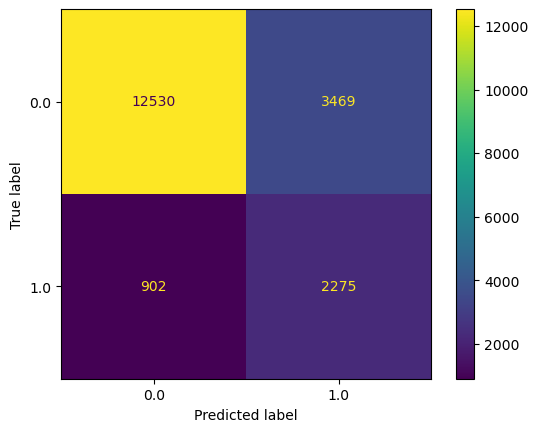

##################################################################


In [54]:
acc = accuracy_score(y_train, y_pred_train)
f1 = f1_score(y_train, y_pred_train)
recall = recall_score(y_train, y_pred_train)
bal_acc = balanced_accuracy_score(y_train, y_pred_train)
precision= precision_score(y_train, y_pred_train)
roc_auc = roc_auc_score(y_train, y_pred_train)



print("Accuracy", f"{acc:.4f}")
print("Precision", f"{precision:.4f}")
print("F1 Score", f"{f1:.4f}")
print("Recall", f"{recall:.4f}")
print("Balanced Accuracy", f"{bal_acc:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")



# Classification Report
print("##################################################################")
print("**Classification Report:**")
print(classification_report(y_train, y_pred_train))

print("##################################################################")


# Confusion Matrix
print("**Confusion Matrix:**")
cm_train = confusion_matrix(y_train, y_pred_train, labels=model.classes_)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=model.classes_)

# disp_train.plot()
# plt.show()
print("##################################################################")
fig, ax = plt.subplots()
disp_train.plot(ax=ax)
st.pyplot(fig)
plt.show()
print("##################################################################")


# Test Model Results

# Comparision Table

In [55]:
# Comparison table
# Sample data for development and validation (replace with actual data)
development_data = pd.DataFrame({
    'Decile':[1,2,3,4,5,6,7,8,9,10],
    'Bad': ks_table_train['Bad'],
    'Good': ks_table_train['Good']
})

validation_data = {
    month: pd.DataFrame({
        'Bad': ks_tables_test[f"KS_TABLE_{month}"]['Bad'],
        'Good': ks_tables_test[f"KS_TABLE_{month}"]['Good']
    })
    for month in test_months
}

# validation_data

# Helper function to calculate cumulative and derived values
def calculate_metrics(data):
    total_bad = data['Bad'].sum()
    total_good = data['Good'].sum()

    data['Total'] = data['Bad'] + data['Good']
    data['Cumulative Bad'] = data['Bad'].cumsum()
    data['Cumulative Good'] = data['Good'].cumsum()
    data['Cumulative Bad%'] = data['Cumulative Bad'] / total_bad
    data['Cumulative Good%'] = data['Cumulative Good'] / total_good
    data['Bad Rate'] = data['Bad'] / data['Total']
    data['%Bad'] = data['Bad'] / total_bad
    data['%Good'] = data['Good'] / total_good
    data['KS'] = data['Cumulative Bad%']-data['Cumulative Good%']
    # Add an 'AUC' column to the DataFrame for transparency
    data['AUC'] =(data['Cumulative Good%'] / 2) * (data['Cumulative Bad%'])
    for i in range(1, len(data)):
        data.at[i, 'AUC'] = ((data['Cumulative Good%'][i] + data['Cumulative Good%'][i-1]) / 2) * (data['Cumulative Bad%'][i] - data['Cumulative Bad%'][i-1])
    data['Rank'] = data['Bad Rate'].rank(ascending=False)
    data['Gini'] =''


    return data, total_bad, total_good

# Calculate for development data
dev_data, dev_total_bad, dev_total_good = calculate_metrics(development_data)

# Calculate for validation data (for each month)
validation_metrics = {}
for month, val_data in validation_data.items():
    val_data, _, _ = calculate_metrics(val_data)
    validation_metrics[month] = val_data



# # Calculate ROB (Rank of Best) for each month
for month, val_data in validation_metrics.items():
    val_data['ROB'] = (dev_data['Rank'] != val_data['Rank']).astype(int)

# # Calculate ROB (Rank of Best) for each month
for month, val_data in validation_metrics.items():
    val_data['Gini'] = ''


# Combine Development Set and Validation Sets side by side
combined_data = dev_data.copy()
for month, val_data in validation_metrics.items():
    # Align the validation data with the development data by index (assuming same number of rows)
    val_data = val_data.rename(columns=lambda x: f"{x} ({month})")  # Rename columns to distinguish months
    combined_data = pd.concat([combined_data, val_data], axis=1)


# Add an overall total row at the end
overall_totals = pd.DataFrame({
        'Decile': ['Overall'],
        'Bad': combined_data['Bad'].sum(axis=0),
        'Good': combined_data['Good'].sum(axis=0),
        'Total': combined_data['Total'].sum(axis=0),
        'Bad Rate': combined_data['Bad'].sum(axis=0)/combined_data['Total'].sum(axis=0),
        '%Bad': combined_data['%Bad'].sum(axis=0),
        '%Good': combined_data['%Good'].sum(axis=0),
        'KS': combined_data['KS'].max(),
        'AUC': combined_data['AUC'].sum(axis=0),
        'Gini': abs(1 - 2 * combined_data['AUC'].sum(axis=0)),

        **{f"Bad ({month})": combined_data[f"Bad ({month})"].sum(axis=0) for month in validation_metrics},
        **{f"Good ({month})": combined_data[f"Good ({month})"].sum(axis=0) for month in validation_metrics},
        **{f"Total ({month})": combined_data[f"Total ({month})"].sum(axis=0) for month in validation_metrics},
        **{f"Bad Rate ({month})": combined_data[f"Bad ({month})"].sum(axis=0)/combined_data[f"Total ({month})"].sum(axis=0) for month in validation_metrics},
        **{f"%Bad ({month})": combined_data[f"%Bad ({month})"].sum(axis=0) for month in validation_metrics},
        **{f"%Good ({month})": combined_data[f"%Good ({month})"].sum(axis=0) for month in validation_metrics},
        **{f"KS ({month})": combined_data[f"KS ({month})"].max() for month in validation_metrics},
        **{f"AUC ({month})": combined_data[f"AUC ({month})"].sum(axis=0) for month in validation_metrics},
        **{f"ROB ({month})": combined_data[f"ROB ({month})"].sum(axis=0)/combined_data[f"ROB ({month})"].count() for month in validation_metrics},
        **{f"Gini ({month})": (abs(1-2*(combined_data[f"AUC ({month})"].sum(axis=0)))) for month in validation_metrics}
})

# Append the overall totals row at the end of the combined data
combined_data_with_totals = pd.concat([combined_data, overall_totals], ignore_index=True)

# Display the final combined data with the overall totals row
combined_data_with_totals


C:\Users\524264.CORP\AppData\Local\Temp\ipykernel_17532\1775653175.py:87: RuntimeWarning: invalid value encountered in scalar divide
  **{f"Bad Rate ({month})": combined_data[f"Bad ({month})"].sum(axis=0)/combined_data[f"Total ({month})"].sum(axis=0) for month in validation_metrics},


Decile     Bad     Good    Total  Cumulative Bad  Cumulative Good  \
0         1  1192.0    725.0   1917.0          1192.0            725.0   
1         2   676.0   1241.0   1917.0          1868.0           1966.0   
2         3   407.0   1510.0   1917.0          2275.0           3476.0   
3         4   248.0   1669.0   1917.0          2523.0           5145.0   
4         5   173.0   1744.0   1917.0          2696.0           6889.0   
5         6   145.0   1772.0   1917.0          2841.0           8661.0   
6         7   115.0   1802.0   1917.0          2956.0          10463.0   
7         8   111.0   1806.0   1917.0          3067.0          12269.0   
8         9    58.0   1859.0   1917.0          3125.0          14128.0   
9        10    52.0   1871.0   1923.0          3177.0          15999.0   
10  Overall  3177.0  15999.0  19176.0             NaN              NaN   

    Cumulative Bad%  Cumulative Good%  Bad Rate      %Bad  ...  \
0          0.375197          0.045315  0.621805  0.375197  ...   
1          0.587976          0.122883  0.352634  0.212779  ...   
2          0.716084          0.217264  0.212311  0.128108  ...   
3          0.794145          0.321583  0.129369  0.078061  ...   
4          0.848599          0.430589  0.090245  0.054454  ...   
5          0.894240          0.541346  0.075639  0.045641  ...   
6          0.930438          0.653978  0.059990  0.036198  ...   
7          0.965376          0.766860  0.057903  0.034939  ...   
8          0.983632          0.883055  0.030256  0.018256  ...   
9          1.000000          1.000000  0.027041  0.016368  ...   
10              NaN               NaN  0.165676  1.000000  ...   

    Cumulative Bad% (MAY25)  Cumulative Good% (MAY25)  Bad Rate (MAY25)  \
0                       NaN                       NaN               NaN   
1                       NaN                       NaN               NaN   
2                       NaN                       NaN               NaN   
3                       NaN                       NaN               NaN   
4                       NaN                       NaN               NaN   
5                       NaN                       NaN               NaN   
6                       NaN                       NaN               NaN   
7                       NaN                       NaN               NaN   
8                       NaN                       NaN               NaN   
9                       NaN                       NaN               NaN   
10                      NaN                       NaN               NaN   

    %Bad (MAY25) %Good (MAY25)  KS (MAY25)  AUC (MAY25)  Rank (MAY25)  \
0            NaN           NaN         NaN          NaN           NaN   
1            NaN           NaN         NaN          NaN           NaN   
2            NaN           NaN         NaN          NaN           NaN   
3            NaN           NaN         NaN          NaN           NaN   
4            NaN           NaN         NaN          NaN           NaN   
5            NaN           NaN         NaN          NaN           NaN   
6            NaN           NaN         NaN          NaN           NaN   
7            NaN           NaN         NaN          NaN           NaN   
8            NaN           NaN         NaN          NaN           NaN   
9            NaN           NaN         NaN          NaN           NaN   
10           0.0           0.0         NaN          0.0           NaN   

    Gini (MAY25)  ROB (MAY25)  
0                         1.0  
1                         1.0  
2                         1.0  
3                         1.0  
4                         1.0  
5                         1.0  
6                         1.0  
7                         1.0  
8                         1.0  
9                         1.0  
10           1.0          1.0  

[11 rows x 30 columns]

In [56]:
cumulative_bad_columns = list(combined_data_with_totals.columns[(combined_data_with_totals.columns.str.startswith("Cumulative Bad%"))|(combined_data_with_totals.columns.str.startswith("Bad Rate"))|(combined_data_with_totals.columns.str.startswith("ROB"))])
# bad_rate_columns=combined_data_with_totals.columns[combined_data_with_totals.columns.str.startswith("Bad Rate")]

# cumulative_bad_columns=['Decile']+cumulative_bad_columns
# print(cumulative_bad_columns)
combined_data_with_totals_V1=combined_data_with_totals[["Decile"]+cumulative_bad_columns]

combined_data_with_totals_V1

Decile  Cumulative Bad%  Bad Rate  Cumulative Bad% (MAY25)  \
0         1         0.375197  0.621805                      NaN   
1         2         0.587976  0.352634                      NaN   
2         3         0.716084  0.212311                      NaN   
3         4         0.794145  0.129369                      NaN   
4         5         0.848599  0.090245                      NaN   
5         6         0.894240  0.075639                      NaN   
6         7         0.930438  0.059990                      NaN   
7         8         0.965376  0.057903                      NaN   
8         9         0.983632  0.030256                      NaN   
9        10         1.000000  0.027041                      NaN   
10  Overall              NaN  0.165676                      NaN   

    Bad Rate (MAY25)  ROB (MAY25)  
0                NaN          1.0  
1                NaN          1.0  
2                NaN          1.0  
3                NaN          1.0  
4                NaN          1.0  
5                NaN          1.0  
6                NaN          1.0  
7                NaN          1.0  
8                NaN          1.0  
9                NaN          1.0  
10               NaN          1.0

# PSI table

In [57]:
# Decile name

Decile='Decile'



def calculate_psi_multiple_tests(train_df, test_dfs, total_pop_col_train, total_pop_cols_test):
    """
    Calculate PSI for multiple test datasets compared to a single train dataset.

    Parameters:
    - train_df: DataFrame for the train KS table.
    - test_dfs: Dictionary of DataFrames for the test KS tables, where keys are test month labels.
    - total_pop_col_train: Column name for total population in the train table.
    - total_pop_cols_test: Dictionary where keys are test month labels, and values are column names for total population in each test table.

    Returns:
    - psi_table: Combined PSI table for all test months.

    """

    # Validate matching keys
    missing_keys = [month for month in test_dfs if month not in total_pop_cols_test]
    if missing_keys:
        raise KeyError(f"Missing keys in total_pop_cols_test for months: {missing_keys}")
    # Ensure the train DataFrame is sorted by decile
    train_df = train_df.sort_values(by=Decile).reset_index(drop=True)
    
    
    # Calculate total train population and population percentage per decile
    total_train_pop = train_df[total_pop_col_train].sum()
    train_df['Train Population %'] = train_df[total_pop_col_train] / total_train_pop
    
    # Initialize the PSI table with train data columns
    psi_table = pd.DataFrame({
        Decile: train_df[Decile],
        'Train Total Population': train_df[total_pop_col_train],
        'Train Population %': train_df['Train Population %']
    })
    
    # Dictionary to store total PSI values for each month
    total_psi_values = {}

    # Calculate PSI for each test month
    for month, test_df in test_dfs.items():
        # st.write("**`Test Month:`**",month)
        # st.write(test_df)
        # st.write(test_dfs)
        # st.write(total_pop_cols_test)
        test_df = test_df.sort_values(by=Decile).reset_index(drop=True)

        
        
        # Calculate total test population and population percentage per decile
        total_test_pop = test_df[total_pop_cols_test[month]].sum()
        test_df['Test Population %'] = test_df[total_pop_cols_test[month]] / total_test_pop
        
        # Calculate PSI for each decile in this test month
        psi_values = (psi_table['Train Population %'] - test_df['Test Population %']) * \
                    np.log(psi_table['Train Population %'] / test_df['Test Population %'])
        
        # Add columns for the test month's population and PSI values
        psi_table[f'{month} Test Total Population'] = test_df[total_pop_cols_test[month]]
        psi_table[f'{month} Test Population %'] = test_df['Test Population %']
        psi_table[f'{month} PSI'] = psi_values
        
        # Store the total PSI for this month
        total_psi_values[month] = psi_values.sum()
    
    # Calculate overall decision based on maximum PSI across all months
    max_total_psi = max(total_psi_values.values())
    if max_total_psi < 0.1:
        psi_decision = 'Stable'
    elif max_total_psi < 0.25:
        psi_decision = 'On Watch'
    else:
        psi_decision = 'Unstable'
    
    # Create a single Total row with the sum of populations and percentages
    total_row = pd.DataFrame({
        Decile: ['Total'],
        'Train Total Population': [train_df[total_pop_col_train].sum()],
        'Train Population %': [train_df['Train Population %'].sum()],
        **{f'{month} Test Total Population': [test_dfs[month][total_pop_cols_test[month]].sum()] for month in test_dfs},
        **{f'{month} Test Population %': [psi_table[f'{month} Test Population %'].sum()] for month in test_dfs},
        **{f'{month} PSI': [total_psi_values[month]] for month in test_dfs}
    })

    # Create a single Decision row with the PSI decision
    decision_row = pd.DataFrame({
        Decile: ['Decision'],
        'Train Total Population': [''],
        'Train Population %': [''],
        **{f'{month} Test Total Population': [''] for month in test_dfs},
        **{f'{month} Test Population %': [''] for month in test_dfs},
        **{f'{month} PSI': [psi_decision] for month in test_dfs}
    })
    
    # Concatenate the PSI table with the single Total and Decision rows
    psi_table = pd.concat([psi_table, total_row, decision_row], ignore_index=True)
    return psi_table


# Automatically extract short month labels (e.g., "Jan" from "JAN25")
def get_short_month(month_code):
    return month_code[:3].capitalize()  # 'JAN' → 'Jan'


# Build train_df dynamically
train_df = ks_table_train

# # Automatically extract short month labels (e.g., "Jan" from "JAN25")
# def get_short_month(month_code):
#     return month_code[:3].capitalize()  # 'JAN' → 'Jan'



# Build test_dfs and total_pop_cols_test dynamically
test_dfs = {
    monthss: ks_tables_test[f"KS_TABLE_{monthss}"]
    for monthss in test_months
}
# test_dfs

# st.write(test_dfs)

total_pop_cols_test = {
    monthss: 'Total Population'
    for monthss in test_months
}
# total_pop_cols_test

# Calculate PSI for multiple test datasets compared to a single train dataset and View test data

# with st.expander("**`View PSI table`**",icon="📅"):
psi_table = calculate_psi_multiple_tests(train_df, test_dfs, 'Total Population', total_pop_cols_test)

# Display the PSI table
psi_table

Decile Train Total Population Train Population %  \
0          1                   1917                0.1   
1          2                   1917                0.1   
2          3                   1917                0.1   
3          4                   1917                0.1   
4          5                   1917                0.1   
5          6                   1917                0.1   
6          7                   1917                0.1   
7          8                   1917                0.1   
8          9                   1917                0.1   
9         10                   1917                0.1   
10     Total                  19170                1.0   
11  Decision                                             

   MAY25 Test Total Population MAY25 Test Population % MAY25 PSI  
0                         82.0                0.072183  0.009067  
1                        250.0                 0.22007  0.094709  
2                         96.0                0.084507  0.002608  
3                        106.0                 0.09331  0.000463  
4                         98.0                0.086268  0.002028  
5                         72.0                 0.06338  0.016699  
6                        158.0                0.139085  0.012894  
7                         41.0                0.036092   0.06513  
8                        106.0                 0.09331  0.000463  
9                        127.0                0.111796  0.001315  
10                      1136.0                     1.0  0.205378  
11                                                      On Watch

# KS table train

In [58]:
ks_table_train

Decile  Total Population Max Probability Min Probability    Good     Bad  \
0       1              1917        0.734429        0.479266   725.0  1192.0   
1       2              1917        0.479266        0.269706  1241.0   676.0   
2       3              1917        0.269703        0.198514  1510.0   407.0   
3       4              1917        0.198502        0.098162  1669.0   248.0   
4       5              1917        0.098162        0.074418  1744.0   173.0   
5       6              1917        0.074418        0.070295  1772.0   145.0   
6       7              1917        0.070295        0.065349  1802.0   115.0   
7       8              1917        0.065349        0.050118  1806.0   111.0   
8       9              1917        0.050118        0.041659  1859.0    58.0   
9      10              1917        0.041659        0.024497  1871.0    52.0   

     Good %     Bad %  Cumulative Good %  Cumulative Bad % Difference  
0  0.045315  0.375197           0.045315          0.375197   0.329881  
1  0.077567  0.212779           0.122883          0.587976   0.465093  
2  0.094381  0.128108           0.217264          0.716084   0.498821  
3  0.104319  0.078061           0.321583          0.794145   0.472563  
4  0.109007  0.054454           0.430589          0.848599   0.418010  
5  0.110757  0.045641           0.541346          0.894240   0.352894  
6  0.112632  0.036198           0.653978          0.930438   0.276459  
7  0.112882  0.034939           0.766860          0.965376   0.198516  
8  0.116195  0.018256           0.883055          0.983632   0.100577  
9  0.116945  0.016368           1.000000          1.000000   0.000000

# KS TEST

In [59]:
for  ks_table_test1 in test_months:

    ks_table_test2=ks_tables_test[f"KS_TABLE_{ks_table_test1}"]
    # st.write(ks_table_test2)
    # Display KS table for selected test month
    print("#######################################################################")
    print(f"**`KS Table for {ks_table_test1}:`**")
    print(ks_table_test2)
    ks_table_test2
    print("#######################################################################")


#######################################################################
**`KS Table for MAY25:`**
   Decile  Total Population Max Probability Min Probability  Good  Bad  \
0       1              82.0        0.734429        0.479266   0.0  0.0   
1       2             250.0        0.479266        0.269706   0.0  0.0   
2       3              96.0        0.269703        0.198514   0.0  0.0   
3       4             106.0        0.198502        0.098162   0.0  0.0   
4       5              98.0        0.098162        0.074418   0.0  0.0   
5       6              72.0        0.074418        0.070295   0.0  0.0   
6       7             158.0        0.070295        0.065349   0.0  0.0   
7       8              41.0        0.065349        0.050118   0.0  0.0   
8       9             106.0        0.050118        0.041659   0.0  0.0   
9      10             127.0        0.041659        0.024497   0.0  0.0   

   Good %  Bad %  Cumulative Good %  Cumulative Bad % Difference  
0     0.0    0.0    

### Train Data

In [60]:
# # Train evaluation metrics
# train_evaluation_df = pd.DataFrame({
#     'Model Name': [model],
#     'Target_Variable': [selected__target_column],
#     'Optimal_Threshold': [optimal_threshold],
#     'ROC_AUC SCORE': [roc_auc],
#     'Accuracy': [accuracy_score(y_train, y_pred_train)],
#     'Precision': [precision_score(y_train, y_pred_train)],
#     'Recall': [recall_score(y_train, y_pred_train)],
#     'F1_Score': [f1_score(y_train, y_pred_train)],
#     'Balanced_Accuracy': [balanced_accuracy_score(y_train, y_pred_train)],
#     'Variable Used in model':[top_features]
# })

# # ----------------------
# # 2. Create Train Confusion Matrix DataFrame
# # ----------------------

# cm_train = confusion_matrix(y_train, y_pred_train, labels=model.classes_)
# train_confusion_matrix_df = pd.DataFrame(
#     cm_train,
#     index=[f"Actual_{cls}" for cls in model.classes_],
#     columns=[f"Predicted_{cls}" for cls in model.classes_]
# )


# # ----------------------
# # 4. Prepare KS Tables (train and tests)
# # ----------------------

# # Train KS Table
# train_ks_table = ks_table_train



In [61]:
# ###
# # Train evaluation metrics
# train_evaluation_df = pd.DataFrame({
#     'Model Name': [model],
#     'Target_Variable': ['TARGET'],
#     'Optimal_Threshold': [optimal_threshold],
#     'Accuracy': [accuracy_score(y_train, y_pred_train)],
#     'Precision': [precision_score(y_train, y_pred_train)],
#     'Recall': [recall_score(y_train, y_pred_train)],
#     'F1_Score': [f1_score(y_train, y_pred_train)],
#     'Balanced_Accuracy': [balanced_accuracy_score(y_train, y_pred_train)],
#     'Variable Used in model':[top_features]
# })

# # ----------------------
# # 2. Create Train Confusion Matrix DataFrame
# # ----------------------

# cm_train = confusion_matrix(y_train, y_pred_train, labels=model.classes_)
# train_confusion_matrix_df = pd.DataFrame(
#     cm_train,
#     index=[f"Actual_{cls}" for cls in model.classes_],
#     columns=[f"Predicted_{cls}" for cls in model.classes_]
# )

# # ----------------------
# # 3. Create Test Evaluation DataFrames
# # ----------------------

# test_evaluation_dfs = {}
# # st.write(month_column)



# for months in test_months:
#     test_data = DATA[DATA[month_column] == months]
    
#     X_test = test_data.drop(drop_columns, axis=1)
#     X_test = X_test[top_features]
#     y_test = test_data[selected__target_column]
    
#     y_prob_cutoff_test = model.predict_proba(X_test)[:, 1]
#     y_pred_test = np.where(y_prob_cutoff_test >= optimal_threshold, 1, 0)

#     test_evaluation_df = pd.DataFrame({
#         'Target_Variable': [selected__target_column],
#         'Month': [months],
#         'Optimal_Threshold': [optimal_threshold],
#         'Accuracy': [accuracy_score(y_test, y_pred_test)],
#         'Precision': [precision_score(y_test, y_pred_test)],
#         'Recall': [recall_score(y_test, y_pred_test)],
#         'F1_Score': [f1_score(y_test, y_pred_test)],
#         'Balanced_Accuracy': [balanced_accuracy_score(y_test, y_pred_test)]
#     })
    
#     test_evaluation_dfs[months] = test_evaluation_df


#     confusion_test= confusion_matrix(y_test, y_pred_test, labels=model.classes_)
#     test_confusion_matrix_df = pd.DataFrame(
#         confusion_test,index=[f"Actual_{cls}" for cls in model.classes_],
#         columns=[f"Predicted_{cls}" for cls in model.classes_])

# # ----------------------
# # 4. Prepare KS Tables (train and tests)
# # ----------------------

# # Train KS Table
# train_ks_table = ks_table_train

# # Test KS Tables
# test_ks_tables = {}
# for month in test_months:
#     test_ks_tables[month] = ks_tables_test[f"KS_TABLE_{month}"]

# Export File

In [62]:
# Clean name1 and model
# name1_clean = file_name_main.replace(" ", "_")
# model_clean = models.replace(" ", "_")



# Final CSV
final_data_csv = df_test_V3.to_excel(f"{path_scoring}\{export_file_name}.xlsx",index=False)
    
# Create Excel with multiple sheets
excel_buffer = io.BytesIO()
with pd.ExcelWriter(rf"{path_scoring}\{export_file_name}_model_summary.xlsx", engine='xlsxwriter') as writer:

    #PSI table
    psi_table.to_excel(writer, sheet_name='PSI_Table', index=False)
    # Comparision Table
    combined_data_with_totals.to_excel(writer, sheet_name='Comparison_Table', index=False)

    # # KS Tables
    # train_ks_table.to_excel(writer, sheet_name="Train_KS_Table", index=False)
    # for month, df in test_ks_tables.items():
    #     safe_month = month.replace("/", "-").replace(" ", "_")
    #     df.to_excel(writer, sheet_name=f"Test_KS_{safe_month}", index=False)

    # # Train Results
    # train_evaluation_df.to_excel(writer, sheet_name='Train_Evaluation', index=False)
    # train_confusion_matrix_df.to_excel(writer, sheet_name='Train_Confusion_Matrix', index=True)

    # # Test Results
    # for month, df in test_evaluation_dfs.items():
    #     safe_month = month.replace("/", "-").replace(" ", "_")  # safe sheet name
    #     df.to_excel(writer, sheet_name=f"Test_Evaluation_{safe_month}", index=False)
    #     test_confusion_matrix_df.to_excel(writer, sheet_name=f"Test_Confusion_Matrix_{safe_month}", index=True)

    
    # # KS Tables
    # train_ks_table.to_excel(writer, sheet_name="Train_KS_Table", index=False)
    
    # # Train Results
    # train_evaluation_df.to_excel(writer, sheet_name='Train_Evaluation', index=False)
    # train_confusion_matrix_df.to_excel(writer, sheet_name='Train_Confusion_Matrix', index=True)

        
        
    

<string>:8: SyntaxWarning: invalid escape sequence '\{'
<>:8: SyntaxWarning: invalid escape sequence '\{'
<string>:8: SyntaxWarning: invalid escape sequence '\{'
<>:8: SyntaxWarning: invalid escape sequence '\{'
C:\Users\524264.CORP\AppData\Local\Temp\ipykernel_17532\4287908986.py:8: SyntaxWarning: invalid escape sequence '\{'
  final_data_csv = df_test_V3.to_excel(f"{path_scoring}\{export_file_name}.xlsx",index=False)


#                               Model Comparision

# Folder Path and files

In [187]:
threshold=optimal_threshold

# Target columns
target_columns=selected__target_column
# target_columns='TARGET'

# New Probability Column
new_probability="Probability"

# Existing model probability column
existing_probability="Pred_Score_1"



# All file location
folder_path_comparision=rf"D:\Pranto\Working\Collection Model\Collection New Model\3 to 3 Plus PV\Data\V1\3 to 3 Plus PV\Comparision"
# folder_path_comparision=rf"C:\Users\524264.CORP\Downloads"

# New model File name
# new_model_file_name=rf"2_TO_2_PLUS_ILCV_model_DEC23_TO_MAR25_Overall_Apply_binning_data_final_data_with_probability"


# new_model_file_name=rf"val_jan_ilcv"

# file1=rf"Final_Datav1_jan"

# files=[file1]
# month_name=['JAN25']

# Existing File name
file1=rf"Bkt_3_PV_JAN25_Score_File"

file2=rf"Bkt_3_PV_FEB25_Score_File"

file3=rf"Bkt_3_PV_MAR25_Score_File 1"



# Existing model files
files=[file1,file2,file3]
month_name=['JAN25','FEB25','MAR25']


# Export File name
export_file_name=rf"3_TO_3_PLUS_PV_model_JAN24_TO_MAR25_New Model"



## Read Files

In [188]:
new_model_df=final_data

# try:
#     new_model_df=pd.read_csv(rf"{folder_path_comparision}\{new_model_file_name}.csv",encoding='latin-1')
# except:
#     new_model_df=pd.read_excel(rf"{folder_path_comparision}\{new_model_file_name}.xlsx")



print("######################################################################")

print("New model file Shape ",new_model_df.shape)
print("New model file Columns ",new_model_df.columns)

print("######################################################################")

dataframes={}

for file,month1 in zip(files,month_name):
    try:
        df_file=pd.read_csv(rf"{folder_path_comparision}\{file}.csv",encoding='latin-1')
        df_file['MONTH']=month1
        dataframes[month1]=df_file

        print("######################################################################")

        print(rf"{month1} file Shape ",df_file.shape)
        print(rf"{month1} Columns ",df_file.columns)

        print("######################################################################")

    except:
        df_file=pd.read_excel(rf"{folder_path_comparision}\{file}.xlsx")
        df_file['MONTH']=month1
        dataframes[month1]=df_file
        print("######################################################################")

        print(rf"{month1} file Shape ",df_file.shape)
        print(rf"{month1} Columns ",df_file.columns)

        print("######################################################################")


existing_model_df = pd.concat(dataframes.values(), ignore_index=True)

print("######################################################################")

print("Existing model shape",existing_model_df.shape)
print("Existing model columns",existing_model_df.columns)
print("######################################################################")


# Merge the new model data with the existing model data on CONNO and MONTH
merged_df = pd.merge(new_model_df, existing_model_df[['CONNO','MONTH',existing_probability]], on=["CONNO", "MONTH"], how="inner")


print("######################################################################")

print("After Merging model shape",merged_df.shape)
print("After Merging model columns",merged_df.columns)
print("######################################################################")

######################################################################
New model file Shape  (22860, 19)
New model file Columns  Index(['CONNO', 'BPNO', 'ODBKT', 'SOHPOD', 'SOHPOD_PREASSIGN', 'MONTH',
       'TARGET_VARIABLE_V1', 'CountInBkt_3_3M_WOE', 'Roll_stable_2_WOE',
       'due_date_WOE', 'RollFw2_WOE', 'last_Month_coll_WOE',
       'CountInBkt_2Plus_3M_WOE', 'nuof_EMI_L3M_WOE', 'DSA_DLR_WOE',
       'BRANCH_WOE', 'PRODUCT_New_WOE', 'Decile', 'Probability'],
      dtype='object')
######################################################################
######################################################################
JAN25 file Shape  (1269, 10)
JAN25 Columns  Index(['CONNO', 'BPNO', 'ODBKT', 'Del_String', 'PRODUCT', 'ASSET_CATEGORY2',
       'Pred_Score_1', 'JANile', 'COMPANY_CODE', 'MONTH'],
      dtype='object')
######################################################################
######################################################################
FEB25 file Shape  (127

In [189]:
target_columns

'TARGET_VARIABLE_V1'

In [190]:
merged_df

CONNO          BPNO  ODBKT     SOHPOD  SOHPOD_PREASSIGN  MONTH  \
0     5002302216  2.002945e+09      3   46407.05          46407.05  JAN25   
1     5002414096  2.003034e+09      3   96838.50          96838.50  JAN25   
2     5002433183  2.003050e+09      3   10679.00          10679.00  JAN25   
3     5002444308  2.003059e+09      3   72795.37          72795.37  JAN25   
4     5002450975  2.003064e+09      3   81885.67          81885.67  JAN25   
...          ...           ...    ...        ...               ...    ...   
3679  5004682650  2.004602e+09      3  543116.91         543116.91  MAR25   
3680  5004685402  2.003245e+09      3  398883.63         398883.63  MAR25   
3681  5004705118  2.004623e+09      3  813080.53         813080.53  MAR25   
3682  8000125007  2.003600e+09      3    3854.00           3854.00  MAR25   
3683  8000167035  2.004032e+09      3   81159.34          81159.34  MAR25   

      TARGET_VARIABLE_V1  CountInBkt_3_3M_WOE  Roll_stable_2_WOE  \
0                      0            -1.260499          -0.714204   
1                      0             1.056520           1.056520   
2                      1            -1.260499          -1.449183   
3                      0             1.056520           1.056520   
4                      1            -1.260499          -1.449183   
...                  ...                  ...                ...   
3679                   1            -1.260499          -0.714204   
3680                   1            -0.343703          -1.449183   
3681                   1             1.056520           1.056520   
3682                   0             1.056520           1.056520   
3683                   0            -0.343703          -0.714204   

      due_date_WOE  RollFw2_WOE  last_Month_coll_WOE  CountInBkt_2Plus_3M_WOE  \
0         0.384264    -0.728023            -1.258251                -1.250521   
1         0.384264     1.030450             0.662357                 0.959966   
2        -0.640515    -1.546208            -1.258251                -1.250521   
3         0.384264     1.030450             0.662357                 0.959966   
4        -0.640515    -1.546208            -1.258251                -1.250521   
...            ...          ...                  ...                      ...   
3679      0.384264    -0.728023            -1.258251                -1.250521   
3680      0.384264    -0.728023            -1.258251                -0.314105   
3681     -0.640515     1.030450             0.662357                 0.959966   
3682      0.384264     1.030450             0.662357                 0.959966   
3683      0.384264    -0.728023             0.662357                -0.314105   

      nuof_EMI_L3M_WOE  DSA_DLR_WOE  BRANCH_WOE  PRODUCT_New_WOE  Decile  \
0            -1.323697    -1.265932   -1.015726        -0.280025     2.0   
1             1.089512     0.612926    0.581573         0.086023    10.0   
2            -1.323697    -1.265932   -1.015726        -0.280025     1.0   
3             1.089512     0.612926    0.581573         0.086023    10.0   
4            -1.323697    -1.265932    0.009378         0.086023     1.0   
...                ...          ...         ...              ...     ...   
3679         -0.492950     0.612926    0.009378        -0.280025     3.0   
3680         -0.492950     0.069408    0.009378         0.843645     4.0   
3681         -0.492950     0.069408   -0.385838        -0.918851     3.0   
3682          1.089512     0.069408   -0.385838         0.086023     6.0   
3683         -0.492950     0.069408    0.009378         0.086023     4.0   

      Probability  Pred_Score_1  
0        0.363346      0.462396  
1        0.037610      0.062855  
2        0.711670      0.741421  
3        0.037610      0.104218  
4        0.640930      0.224748  
...           ...           ...  
3679     0.199472      0.160161  
3680     0.190270      0.421509  
3681     0.267703      0.342156  
3682     0.070315      0.417084  
3683     

# Comparision

In [191]:



# Evaluation function
def evaluate_model(y_true, y_prob, threshold=threshold, top_pct=0.3):
    df = pd.DataFrame({'y_true': y_true, 'y_prob': y_prob})
    df['y_pred'] = (df['y_prob'] >= threshold).astype(int)
    cutoff = int(len(df) * top_pct)
    df_sorted = df.sort_values('y_prob', ascending=False).reset_index(drop=True)
    top_bads = df_sorted.iloc[:cutoff]['y_true'].sum()
    total_bads = df['y_true'].sum()
    capture_rate = top_bads / total_bads if total_bads else 0
    lift = (top_bads / cutoff) / (total_bads / len(df)) if total_bads else 0

    return {
        'AUC': roc_auc_score(y_true, y_prob),
        'Accuracy': accuracy_score(y_true, df['y_pred']),
        'Precision': precision_score(y_true, df['y_pred']),
        'Recall': recall_score(y_true, df['y_pred']),
        'F1 Score': f1_score(y_true, df['y_pred']),
        'Top_30%_Bad_Capture_Rate': capture_rate,
        'Lift_Top_30%': lift
    }


def calculate_group_metrics(df, target_column, probability_column):
    """
    Calculate metrics for High, Medium, and Low probability groups.
    """
    # Create probability-based groups
    df = df.copy()
    high_threshold = df[probability_column].quantile(0.7)
    low_threshold = df[probability_column].quantile(0.3)

    conditions = [
        df[probability_column] > high_threshold,
        (df[probability_column] > low_threshold) & (df[probability_column] <= high_threshold),
        df[probability_column] <= low_threshold
    ]
    choices = ['High', 'Medium', 'Low']
    df['Group'] = np.select(conditions, choices, default='Unknown')

    # Initialize metrics
    metrics = []

    total_population = len(df)
    total_bads = df[target_column] .sum()

    for group in ['High', 'Medium', 'Low']:
        group_data = df[df['Group'] == group]
        total = len(group_data)
        good = (group_data[target_column] == 0).sum()
        bad = (group_data[target_column] == 1).sum()
        bad_rate = bad / total if total > 0 else 0
        population_pct = total / total_population if total_population > 0 else 0
        bad_capture_rate = bad / total_bads if total_bads > 0 else 0
        lift = bad_rate / (total_bads / total_population) if total_population > 0 and total_bads > 0 else 0

        metrics.append({
            'Group': group,
            'Good': good,
            'Bad': bad,
            'Total': total,
            'Bad Rate': round(bad_rate, 4),
            'Bad Capture Rate': round(bad_capture_rate, 4),
            'Population %': round(population_pct, 4),
            'Lift': round(lift, 2)
        })

    return pd.DataFrame(metrics)




results = []
group_metrics_all_months = []

for month2 in month_name:
    temp = merged_df[merged_df['MONTH'] == month2]
    
    # For New Model metrics
    metrics_new = evaluate_model(temp[target_columns], temp[new_probability])
    metrics_new.update({'Month': month2, 'Model': 'NEW_MODEL'})
    results.append(metrics_new)
    
    # For Existing Model metrics
    metrics_existing = evaluate_model(temp[target_columns], temp[existing_probability])
    metrics_existing.update({'Month': month2, 'Model': 'EXISTING_MODEL'})
    results.append(metrics_existing)
    
    # Group Metrics for New Model
    group_metrics_new = calculate_group_metrics(temp, target_columns, new_probability)
    group_metrics_new['Model'] = 'NEW_MODEL'
    group_metrics_new['Month'] = month2
    group_metrics_all_months.append(group_metrics_new)

    # Group Metrics for Existing Model
    group_metrics_existing = calculate_group_metrics(temp, target_columns, existing_probability)
    group_metrics_existing['Model'] = 'EXISTING_MODEL'
    group_metrics_existing['Month'] = month2
    group_metrics_all_months.append(group_metrics_existing)

# Convert performance results into a DataFrame
results_df = pd.DataFrame(results)

results_df_V1=results_df[['Month', 'Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 
                  'Top_30%_Bad_Capture_Rate', 'Lift_Top_30%']]

# Combine the group metrics from all months
group_metrics_df = pd.concat(group_metrics_all_months, ignore_index=True)

group_metrics_df_V1=group_metrics_df[['Month', 'Model', 'Group', 'Good', 'Bad', 'Total', 'Bad Rate', 
                        'Bad Capture Rate', 'Population %', 'Lift']]





### Performance Metrics

In [192]:

results_df_V1


Month           Model       AUC  Accuracy  Precision    Recall  F1 Score  \
0  JAN25       NEW_MODEL  0.817752  0.796369   0.416431  0.738693  0.532609   
1  JAN25  EXISTING_MODEL  0.667010  0.734017   0.293413  0.492462  0.367730   
2  FEB25       NEW_MODEL  0.804806  0.765674   0.372032  0.698020  0.485370   
3  FEB25  EXISTING_MODEL  0.707538  0.776646   0.317181  0.356436  0.335664   
4  MAR25       NEW_MODEL  0.763024  0.781770   0.486395  0.593361  0.534579   
5  MAR25  EXISTING_MODEL  0.637619  0.540754   0.270665  0.692946  0.389277   

   Top_30%_Bad_Capture_Rate  Lift_Top_30%  
0                  0.748744      2.496469  
1                  0.547739      1.826276  
2                  0.702970      2.348142  
3                  0.594059      1.984345  
4                  0.655602      2.187256  
5                  0.464730      1.550460

#### Group Metrics

In [193]:

group_metrics_df_V1

Month           Model   Group  Good  Bad  Total  Bad Rate  \
0   JAN25       NEW_MODEL    High   231  149    380    0.3921   
1   JAN25       NEW_MODEL  Medium   376   26    402    0.0647   
2   JAN25       NEW_MODEL     Low   461   24    485    0.0495   
3   JAN25  EXISTING_MODEL    High   271  109    380    0.2868   
4   JAN25  EXISTING_MODEL  Medium   449   58    507    0.1144   
5   JAN25  EXISTING_MODEL     Low   348   32    380    0.0842   
6   FEB25       NEW_MODEL    High   240  142    382    0.3717   
7   FEB25       NEW_MODEL  Medium   379   37    416    0.0889   
8   FEB25       NEW_MODEL     Low   455   23    478    0.0481   
9   FEB25  EXISTING_MODEL    High   263  120    383    0.3133   
10  FEB25  EXISTING_MODEL  Medium   452   58    510    0.1137   
11  FEB25  EXISTING_MODEL     Low   359   24    383    0.0627   
12  MAR25       NEW_MODEL    High   184  158    342    0.4620   
13  MAR25       NEW_MODEL  Medium   316   41    357    0.1148   
14  MAR25       NEW_MODEL     Low   400   42    442    0.0950   
15  MAR25  EXISTING_MODEL    High   230  112    342    0.3275   
16  MAR25  EXISTING_MODEL  Medium   371   85    456    0.1864   
17  MAR25  EXISTING_MODEL     Low   299   44    343    0.1283   

    Bad Capture Rate  Population %  Lift  
0             0.7487        0.2999  2.50  
1             0.1307        0.3173  0.41  
2             0.1206        0.3828  0.32  
3             0.5477        0.2999  1.83  
4             0.2915        0.4002  0.73  
5             0.1608        0.2999  0.54  
6             0.7030        0.2994  2.35  
7             0.1832        0.3260  0.56  
8             0.1139        0.3746  0.30  
9             0.5941        0.3002  1.98  
10            0.2871        0.3997  0.72  
11            0.1188        0.3002  0.40  
12            0.6556        0.2997  2.19  
13            0.1701        0.3129  0.54  
14            0.1743        0.3874  0.45  
15            0.4647        0.2997  1.55  
16            0.3527        0.3996  0.88  
17            0.1826        0.3006  0.61

# Export Comparision Table

In [196]:
   
# Create Excel with multiple sheets
excel_buffer = io.BytesIO()
with pd.ExcelWriter(rf"{folder_path_comparision}\{export_file_name}_{model_clean}_Model_Comparision.xlsx", engine='xlsxwriter') as writer:

    #PSI table
    group_metrics_df_V1.to_excel(writer, sheet_name='Group Metrics', index=False)
    # Comparision Table
    results_df_V1.to_excel(writer, sheet_name='Evaluation Metrics', index=False)


In [170]:
# model_results=st.selectbox("",["Train Data","Test Data"],key='model_result')
#     if model_results == "Train Data":
#         # Streamlit UI: select train month
#         # Evaluation metrics
#         acc = accuracy_score(y_train, y_pred_train)
#         f1 = f1_score(y_train, y_pred_train)
#         recall = recall_score(y_train, y_pred_train)
#         bal_acc = balanced_accuracy_score(y_train, y_pred_train)
#         precision= precision_score(y_train, y_pred_train)

#         st.divider()

#         col1,col2,col3,col4,col5=st.columns(5)
#         with col1:
#             st.metric("Accuracy", f"{acc:.4f}")
#         with col2:
#             st.metric("Precision", f"{precision:.4f}")
#         with col3:
#             st.metric("F1 Score", f"{f1:.4f}")
#         with col4:
#             st.metric("Recall", f"{recall:.4f}")
#         with col5:
#             st.metric("Balanced Accuracy", f"{bal_acc:.4f}")
#         # # Display metrics
#         # st.write(f"**Accuracy:** `{acc:.4f}`")
#         # st.write(f"**F1 Score:** `{f1:.4f}`")
#         # st.write(f"**Recall:** `{recall:.4f}`")
#         # st.write(f"**Balanced Accuracy:** `{bal_acc:.4f}`")

#         # Create dataframe of metrics
#         metrics_df_train = pd.DataFrame({
#             'Metric': ['Accuracy', 'F1 Score', 'Recall', 'Balanced Accuracy'],
#             'Score': [acc, f1, recall, bal_acc]
#         })

#         # Show as table
#         # st.dataframe(metrics_df_train, use_container_width=True)

#         # # Export as CSV
#         # csv = metrics_df.to_csv(index=False).encode('utf-8')
#         # st.download_button("📥 Download Metrics CSV", csv, "train_metrics.csv", "text/csv")

#         st.markdown("---")
#         st.write("**Classification Report:**")
#         st.code(classification_report(y_train, y_pred_train))

#         # Confusion Matrix
#         st.write("**Confusion Matrix:**")
#         cm_train = confusion_matrix(y_train, y_pred_train, labels=model.classes_)
#         disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=model.classes_)

#         fig, ax = plt.subplots()
#         disp_train.plot(ax=ax)
#         st.pyplot(fig)
#         pass

#     # For test months
#     else:
#         st.info("**`There is only train data for model building`**")
        


# st.divider()

# #############%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# #############%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


# #############%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# #############%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# # View KS table
# st.markdown("<h2 style='color: #334fff; font-size: 30px;'>View KS table</h2>", unsafe_allow_html=True)

# # EXPANDER FOR KS TABLE
# with st.expander("**`View KS Table table`**",icon="📅"):

#     ks_table_train_test=st.selectbox("**`Select KS table for train and test data`**",["Train Data","Test Data"],key='ks_table')

#     if ks_table_train_test == "Train Data":
#         # Display KS table for training data
#         st.write("**KS Table for Training Data:**")
#         st.dataframe(ks_table_train, use_container_width=True)
#     else:
#         st.info("**`There is only train data for model building`**")


# # download all results
# ##############################################################################################

# ###
# # Train evaluation metrics
# train_evaluation_df = pd.DataFrame({
#     'Model Name': [model],
#     'Target_Variable': ['TARGET'],
#     'Optimal_Threshold': [optimal_threshold],
#     'Accuracy': [accuracy_score(y_train, y_pred_train)],
#     'Precision': [precision_score(y_train, y_pred_train)],
#     'Recall': [recall_score(y_train, y_pred_train)],
#     'F1_Score': [f1_score(y_train, y_pred_train)],
#     'Balanced_Accuracy': [balanced_accuracy_score(y_train, y_pred_train)],
#     'Variable Used in model':[top_features]
# })

# # ----------------------
# # 2. Create Train Confusion Matrix DataFrame
# # ----------------------

# cm_train = confusion_matrix(y_train, y_pred_train, labels=model.classes_)
# train_confusion_matrix_df = pd.DataFrame(
#     cm_train,
#     index=[f"Actual_{cls}" for cls in model.classes_],
#     columns=[f"Predicted_{cls}" for cls in model.classes_]
# )


# # ----------------------
# # 4. Prepare KS Tables (train and tests)
# # ----------------------

# # Train KS Table
# train_ks_table = ks_table_train



# # ----------------------
# # 5. Export everything into a ZIP
# # ----------------------

# # Clean name1 and model
# name1_clean = name1.replace(" ", "_")
# model_clean = models.replace(" ", "_")

# # Create in-memory zip file
# zip_buffer = io.BytesIO()
# # name1_clean = name1.replace(" ", "_")

# with zipfile.ZipFile(zip_buffer, "w") as zip_file:

#     # Final CSV
#     final_data_csv = final_data.to_csv(index=False)
#     zip_file.writestr(f"{name1_clean}_final_data_with_probability.csv", final_data_csv)

#     # Create Excel with multiple sheets
#     excel_buffer = io.BytesIO()
#     with pd.ExcelWriter(excel_buffer, engine='xlsxwriter') as writer:
        
#         # KS Tables
#         train_ks_table.to_excel(writer, sheet_name="Train_KS_Table", index=False)
        
#         # Train Results
#         train_evaluation_df.to_excel(writer, sheet_name='Train_Evaluation', index=False)
#         train_confusion_matrix_df.to_excel(writer, sheet_name='Train_Confusion_Matrix', index=True)

        
        
#     # Save Excel inside ZIP
#     zip_file.writestr(f"{name1_clean}_{model_clean}_model_summary.xlsx", excel_buffer.getvalue())

# # ----------------------
# # 6. Download Button in Streamlit
# # ----------------------

# st.success("✅ All data prepared successfully!")

# st.divider()

# st.download_button(
#     label="**`📩 Download Results ZIP ⬇`**",
#     data=zip_buffer.getvalue(),
#     file_name=f"{name1_clean}_model_results.zip",
#     mime="application/zip"
# )

# st.divider()

# #############%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# #############%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


In [171]:
# # Function to calculate metrics for probability percentiles (High, Medium, Low)
# def calculate_group_metrics(df, y_true, y_prob, percentile_1=0.3, percentile_2=0.7):
#     # df = pd.DataFrame({'y_true': y_true, 'y_prob': y_prob})
#     # Assign groups based on probability percentiles
#     low_threshold = df[y_prob].quantile(percentile_1)
#     high_threshold = df[y_prob].quantile(percentile_2)
    
#     df['Group'] = 'Low'
#     df.loc[df[y_prob] > high_threshold, 'Group'] = 'High'
#     df.loc[(df[y_prob] > low_threshold) & (df[y_prob] <= high_threshold), 'Group'] = 'Medium'
    
#     # Group-based metrics calculation
#     metrics = []
#     for group in ['High', 'Medium', 'Low']:
#         group_data = df[df['Group'] == group]
#         total = len(group_data)
#         good = (group_data['y_true'] == 0).sum()
#         bad = (group_data['y_true'] == 1).sum()
#         bad_rate = bad / total if total > 0 else 0
#         bad_capture_rate = bad / df['y_true'].sum() if df['y_true'].sum() > 0 else 0
#         population_pct = total / len(df)
#         lift = bad_capture_rate / (total / len(df)) if total > 0 else 0

#         metrics.append({
#             'Group': group,
#             'Good': good,
#             'Bad': bad,
#             'Total': total,
#             'Bad Rate': bad_rate,
#             'Bad Capture Rate': bad_capture_rate,
#             'Population%': population_pct,
#             'Lift': lift
#         })
    
#     return pd.DataFrame(metrics)

# Combine all metrics results
# results = []
# for month2 in month_name:
#     temp = merged_df[merged_df['MONTH'] == month2]
    
#     # For New Model metrics
#     metrics_new = evaluate_model(temp[target_columns], temp[new_probability])
#     metrics_new.update({'Month': month2, 'Model': 'NEW_MODEL'})
#     results.append(metrics_new)
    
#     # For Existing Model metrics
#     metrics_existing = evaluate_model(temp[target_columns], temp[existing_probability])
#     metrics_existing.update({'Month': month2, 'Model': 'EXISTING_MODEL'})
#     results.append(metrics_existing)

# # Convert results into a DataFrame
# results_df = pd.DataFrame(results)

# # Print the final table with all metrics for both models
# print("Model Performance Comparison (AUC, Accuracy, Precision, Recall, F1 Score, Top 30% Bad Capture Rate, Lift):")
# print(results_df[['Month', 'Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 
#                   'Top_30%_Bad_Capture_Rate', 'Lift_Top_30%']])

# # Now calculate and display metrics for High, Medium, and Low probability groups
# group_metrics_new = calculate_group_metrics(merged_df, target_columns, new_probability)
# group_metrics_new['Model'] = 'NEW_MODEL'

# group_metrics_existing = calculate_group_metrics(merged_df, target_columns, existing_probability)
# group_metrics_existing['Model'] = 'EXISTING_MODEL'

# # Combine the group metrics
# group_metrics_df = pd.concat([group_metrics_new, group_metrics_existing], ignore_index=True)

# # Display the group metrics table
# print("\nHigh, Medium, Low Group Metrics for Both Models:")
# group_metrics_df[['Model', 'Group', 'Good', 'Bad', 'Total', 'Bad Rate', 
#                         'Bad Capture Rate', 'Population %', 'Lift']]


In [172]:
# # Comparison table
# # Sample data for development and validation (replace with actual data)
# development_data = pd.DataFrame({
#     'Decile':[1,2,3,4,5,6,7,8,9,10],
#     'Bad': ks_table_train['Good'],
#     'Good': ks_table_train['Bad']
# })

# validation_data = {
#     month: pd.DataFrame({
#         'Bad': ks_tables_test[f"KS_TABLE_{month}"]['Good'],
#         'Good': ks_tables_test[f"KS_TABLE_{month}"]['Bad']
#     })
#     for month in test_months
# }

# # validation_data

# # Helper function to calculate cumulative and derived values
# def calculate_metrics(data):
#     total_bad = data['Bad'].sum()
#     total_good = data['Good'].sum()

#     data['Total'] = data['Bad'] + data['Good']
#     data['Cumulative Bad'] = data['Bad'].cumsum()
#     data['Cumulative Good'] = data['Good'].cumsum()
#     data['Cumulative Bad%'] = data['Cumulative Bad'] / total_bad
#     data['Cumulative Good%'] = data['Cumulative Good'] / total_good
#     data['Good Rate'] = data['Good'] / data['Total']
#     data['%Bad'] = data['Bad'] / total_bad
#     data['%Good'] = data['Good'] / total_good
#     data['KS'] = data['Cumulative Good%'] - data['Cumulative Bad%']
#     # Add an 'AUC' column to the DataFrame for transparency
#     data['AUC'] =(data['Cumulative Good%'] / 2) * (data['Cumulative Bad%'])
#     for i in range(1, len(data)):
#         data.at[i, 'AUC'] = ((data['Cumulative Good%'][i] + data['Cumulative Good%'][i-1]) / 2) * (data['Cumulative Bad%'][i] - data['Cumulative Bad%'][i-1])
#     data['Rank'] = data['Good Rate'].rank(ascending=False)
#     data['Gini'] =''


#     return data, total_bad, total_good

# # Calculate for development data
# dev_data, dev_total_bad, dev_total_good = calculate_metrics(development_data)

# # Calculate for validation data (for each month)
# validation_metrics = {}
# for month, val_data in validation_data.items():
#     val_data, _, _ = calculate_metrics(val_data)
#     validation_metrics[month] = val_data



# # # Calculate ROB (Rank of Best) for each month
# for month, val_data in validation_metrics.items():
#     val_data['ROB'] = (dev_data['Rank'] != val_data['Rank']).astype(int)

# # # Calculate ROB (Rank of Best) for each month
# for month, val_data in validation_metrics.items():
#     val_data['Gini'] = ''


# # Combine Development Set and Validation Sets side by side
# combined_data = dev_data.copy()
# for month, val_data in validation_metrics.items():
#     # Align the validation data with the development data by index (assuming same number of rows)
#     val_data = val_data.rename(columns=lambda x: f"{x} ({month})")  # Rename columns to distinguish months
#     combined_data = pd.concat([combined_data, val_data], axis=1)


# # Add an overall total row at the end
# overall_totals = pd.DataFrame({
#         'Decile': ['Overall'],
#         'Bad': combined_data['Bad'].sum(axis=0),
#         'Good': combined_data['Good'].sum(axis=0),
#         'Total': combined_data['Total'].sum(axis=0),
#         'Good Rate': combined_data['Good'].sum(axis=0)/combined_data['Total'].sum(axis=0),
#         '%Bad': combined_data['%Bad'].sum(axis=0),
#         '%Good': combined_data['%Good'].sum(axis=0),
#         'KS': combined_data['KS'].max(),
#         'AUC': combined_data['AUC'].sum(axis=0),
#         'Gini': abs(1 - 2 * combined_data['AUC'].sum(axis=0)),

#         **{f"Bad ({month})": combined_data[f"Bad ({month})"].sum(axis=0) for month in validation_metrics},
#         **{f"Good ({month})": combined_data[f"Good ({month})"].sum(axis=0) for month in validation_metrics},
#         **{f"Total ({month})": combined_data[f"Total ({month})"].sum(axis=0) for month in validation_metrics},
#         **{f"Good Rate ({month})": combined_data[f"Good ({month})"].sum(axis=0)/combined_data[f"Total ({month})"].sum(axis=0) for month in validation_metrics},
#         **{f"%Bad ({month})": combined_data[f"%Bad ({month})"].sum(axis=0) for month in validation_metrics},
#         **{f"%Good ({month})": combined_data[f"%Good ({month})"].sum(axis=0) for month in validation_metrics},
#         **{f"KS ({month})": combined_data[f"KS ({month})"].max() for month in validation_metrics},
#         **{f"AUC ({month})": combined_data[f"AUC ({month})"].sum(axis=0) for month in validation_metrics},
#         **{f"ROB ({month})": combined_data[f"ROB ({month})"].sum(axis=0)/combined_data[f"ROB ({month})"].count() for month in validation_metrics},
#         **{f"Gini ({month})": (abs(1-2*(combined_data[f"AUC ({month})"].sum(axis=0)))) for month in validation_metrics}
# })

# # Append the overall totals row at the end of the combined data
# combined_data_with_totals = pd.concat([combined_data, overall_totals], ignore_index=True)

# # Display the final combined data with the overall totals row
# combined_data_with_totals
